In [1]:
import os
import shutil
import subprocess
import tempfile
import intake
import fsspec

import dask.diagnostics
import numpy as np
import pandas as pd
import proplot
import vcm.fv3
import xarray as xr

from vcm.catalog import catalog



In [2]:
TIME_RANGE = slice("2020-01-01", "2020-12-31")

BASELINE = "gs://vcm-ml-experiments/n2f-pire-sfc-updates/2022-01-10/baseline-seaice-prescribed/fv3gfs_run"
CATALOG_FINE_RES_DYN = "2020_1yr_pire_dyn"
CATALOG_FINE_RES_PHY = "2020_1yr_pire_physics"
INDEX = pd.Index(["baseline", "fine-resolution"], name="configuration")
_KG_M2S_TO_MM_DAY = (1e3 * 86400) / 997.0
_KG_M2_TO_MM = 1000. / 997.0


def open_run_data():
    baseline_pwat = intake.open_zarr(os.path.join(BASELINE, "atmos_dt_atmos.zarr")).to_dask()[["PWAT"]] \
        .sel(time=TIME_RANGE).resample(time="1M").mean()
    baseline_precip = (intake.open_zarr(os.path.join(BASELINE, "sfc_dt_atmos.zarr")).to_dask()[["PRATEsfc"]] * _KG_M2S_TO_MM_DAY) \
        .sel(time=TIME_RANGE).resample(time="1M").mean() \
        .rename({"PRATEsfc": "total_precipitation_rate"})
    baseline = xr.merge([baseline_pwat, baseline_precip])
    
    verif_pwat = catalog[CATALOG_FINE_RES_DYN].read()[["PWAT"]] \
        .sel(time=TIME_RANGE).resample(time="1M").mean()
    verif_precip = (catalog[CATALOG_FINE_RES_PHY].read()[["PRATEsfc_coarse"]].rename({"PRATEsfc_coarse": "total_precipitation_rate"}) * _KG_M2S_TO_MM_DAY) \
        .sel(time=TIME_RANGE).resample(time="1M").mean()
    verif = xr.merge([verif_pwat, verif_precip])
    
    return xr.concat([baseline, verif], dim=INDEX)

In [4]:
IMAGE = "us.gcr.io/vcm-ml/post_process_run:f59deea7c7f1e94d74844655330301be3149a4db"
DOCKER_IN = "/tmp/data"
DOCKER_OUT = "/tmp/data.nc"
FREGRID = "fregrid_cubed_to_latlon.sh"

ERA5 = "gs://vcm-ml-experiments/n2f-pire-stable-ml/data/era5_pwat.nc"
GPCP = "gs://vcm-ml-experiments/spencerc/2022-05-13-observations/GPCP-precipitation-19790101-20210930/monthly-means-72x144.nc"

BASELINE_TIME = slice("2020-01-01", "2020-12-31")
FINE_RESOLUTION_TIME =  slice("2020-01-01", "2020-12-31")
SECONDS_PER_DAY = 86400



def add_fregrid_metadata(ds):
    #ds = ds.rename({"x": "grid_xt", "y": "grid_yt"})
    ds["grid_xt"] = ds.grid_xt.assign_attrs({"cartesian_axis": "X"})
    ds["grid_yt"] = ds.grid_yt.assign_attrs({"cartesian_axis": "Y"})
    return ds


def get_regridding_fields(ds):
    regridding_fields = []
    for variable in ds.data_vars:
        if "tile" in ds[variable].dims:
            regridding_fields.append(variable)
    return ",".join(regridding_fields)


def get_input_stem(tmpdir):
    return os.path.join(tmpdir, "data")


def write_tiles(ds, tmpdir):
    input_stem = get_input_stem(tmpdir)
    for tile in range(6):
        filename = f"{input_stem}.tile{tile + 1}.nc"
        ds.isel(tile=tile).to_netcdf(filename)


def fregrid_bind_mounts(tmpdir):
    input_stem = get_input_stem(tmpdir)
    bind_mounts = []
    for tile in range(1, 7):
        bind_mounts.extend(["-v", f"{input_stem}.tile{tile}.nc:{DOCKER_IN}.tile{tile}.nc"])
    bind_mounts.extend(["-v", f"{tmpdir}:{DOCKER_OUT}"])
    return bind_mounts


def authentication():
    g = "GOOGLE_APPLICATION_CREDENTIALS"
    credentials = os.environ[g]
    return ["-e", f"{g}={credentials}"]


def infer_resolution(ds):
    return f"C{ds.sizes['grid_xt']}"

        
def regrid(ds, nlat=72, nlon=144):
    subprocess.call(["docker", "image", "pull", IMAGE])
    ds = add_fregrid_metadata(ds)
    fields = get_regridding_fields(ds)
    resolution = infer_resolution(ds)
            
    with tempfile.TemporaryDirectory() as tmpdir:
        output_file = os.path.join(tmpdir, "data.nc")
        write_tiles(ds, tmpdir)
        
        call = (
            ["docker", "run"] + 
            authentication() + 
            fregrid_bind_mounts(tmpdir) +
            [IMAGE, FREGRID, DOCKER_IN, DOCKER_OUT, resolution, fields] +
            ["--nlat", str(nlat), "--nlon", str(nlon)]
        )
        
        output = subprocess.check_output(call)
        regridded = xr.open_dataset(output_file).load()
        return regridded.rename({"grid_xt": "lon", "grid_yt": "lat"})
    
    
def regrid_along_dim(ds, dim):
    """fregrid cannot handle a string 'configuration' dimension"""
    datasets = {}
    for coord in ds[dim]:
        datasets[coord.item()] = regrid(ds.sel({dim: coord}))
    return xr.concat(datasets.values(), dim=pd.Index(datasets.keys(), name=dim))

In [6]:

def open_tape(rundir, tape):
    """Open a zarr store from a particular run directory"""
    basename = f"{tape}.zarr"
    url = os.path.join(rundir, basename)
    mapper = fsspec.get_mapper(url)
    ds = xr.open_zarr(mapper)
    return vcm.fv3.standardize_fv3_diagnostics(ds)


def open_tape_sequence(rundirs, tape, concat_dim="climate"):
    """Open a tape from a sequence of run directories"""
    datasets = {}
    for key, rundir in rundirs.items():
        datasets[key] = open_tape(rundir, tape)
    index = pd.Index(datasets.keys(), name=concat_dim)
    return xr.concat(datasets.values(), dim=index)


def open_remote_nc(url):
    fs, *_ = fsspec.get_fs_token_paths(url)
    return vcm.open_remote_nc(fs, url)



def load_observations(lon, lat):
    observations_pwat = open_remote_nc(ERA5).tcw.rename("PWAT")

    observations_precip = open_remote_nc(GPCP).precip.sel(time=TIME_RANGE).rename("total_precipitation_rate")
    observations_precip = observations_precip.weighted(observations_precip.time.dt.days_in_month).mean("time")

    # Here we replace the lon and lat coordinates with those from fregrid so that
    # they can be properly aligned with the model data.  Otherwise they differ by
    # floating point error and cannot be aligned.
    observations_precip = observations_precip.assign_coords(lat=lat, lon=lon)
    
    return xr.merge([observations_pwat, observations_precip])


def compute_rmse(bias):
    return np.sqrt((bias ** 2).weighted(np.cos(np.deg2rad(bias.lat))).mean(["lon", "lat"]))

In [7]:

with dask.diagnostics.ProgressBar():
    ds = open_run_data().load()
    
regridded = regrid_along_dim(ds.mean("time").squeeze(), "configuration")

observations = load_observations(regridded.lon, regridded.lat)
bias = regridded - observations.sel(longitude=regridded.lon, latitude=regridded.lat).mean("time")
rmse = compute_rmse(bias)

[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed | 30.1s
[########################################] | 100% Completed |  7.0s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

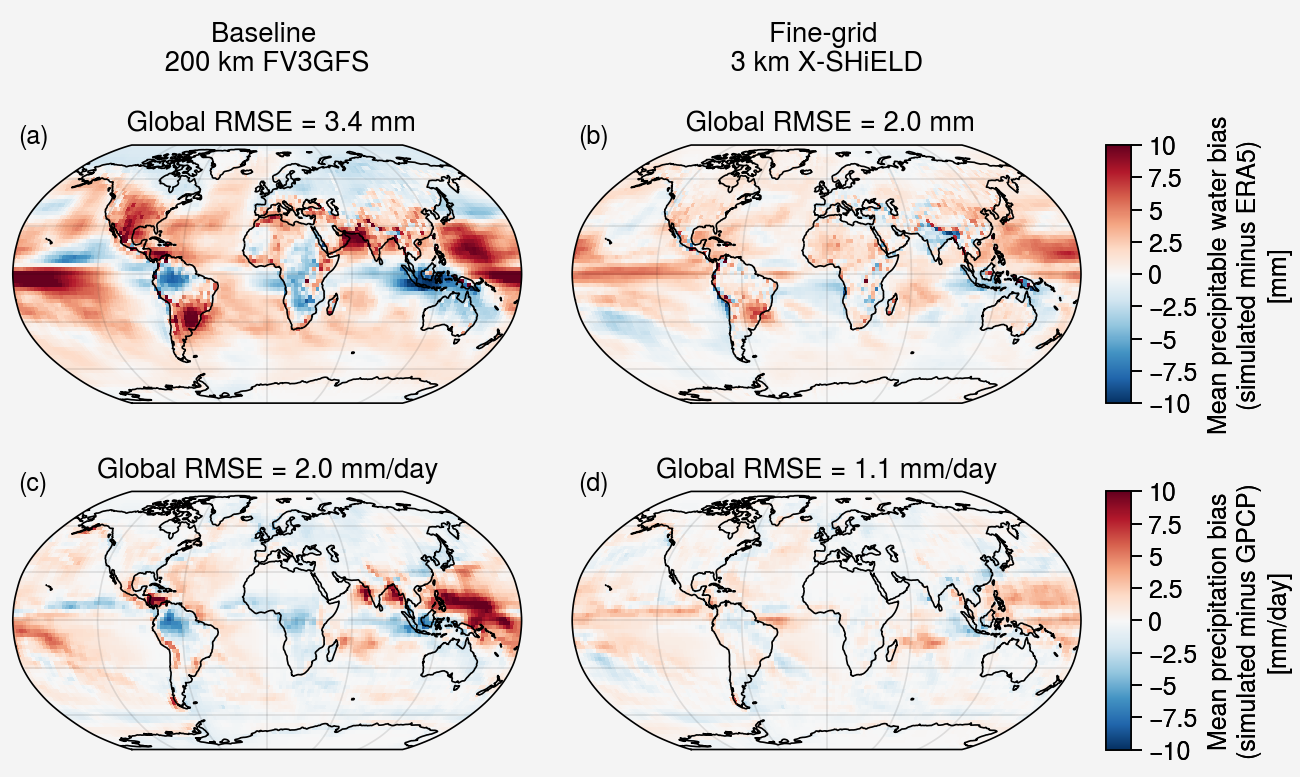

In [11]:
fig, axes = proplot.subplots(ncols=2, nrows=2, proj="robin", figwidth=6.5, refaspect=2., pad=2)

for ax, configuration in zip(axes, bias.configuration):
    p1 = bias.PWAT.sel(configuration=configuration).plot(ax=ax, vmin=-10, vmax=10, cmap="RdBu_r", add_colorbar=False, discrete=False)
    ax.coastlines()
    
axes[0].set_title(f"Baseline \n 200 km FV3GFS \n \n Global RMSE = {(_KG_M2_TO_MM * rmse.PWAT).sel(configuration='baseline').item():0.1f} mm")
axes[1].set_title(f"Fine-grid \n 3 km X-SHiELD \n \n Global RMSE = {(_KG_M2_TO_MM * rmse.PWAT).sel(configuration='fine-resolution').item():0.1f} mm")
axes[0].annotate("(a)", xy=(0, 1.1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')
axes[1].annotate("(b)", xy=(0, 1.1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')

for ax, configuration in zip(axes[2:], bias.configuration):
    p2 = bias.total_precipitation_rate.sel(configuration=configuration).plot(ax=ax, vmin=-10, vmax=10, cmap="RdBu_r", add_colorbar=False, discrete=False)
    ax.coastlines()
    
axes[2].set_title(f"Global RMSE = {rmse.total_precipitation_rate.sel(configuration='baseline').item():0.1f} mm/day")
axes[3].set_title(f"Global RMSE = {rmse.total_precipitation_rate.sel(configuration='fine-resolution').item():0.1f} mm/day")
axes[2].annotate("(c)", xy=(0, 1.1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')
axes[3].annotate("(d)", xy=(0, 1.1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')

fig.colorbar(
    p1,
    rows=[1],
    loc="right",
    width=0.125,
    label="Mean precipitable water bias\n(simulated minus ERA5)\n[mm]"
)

fig.colorbar(
    p2,
    rows=[2],
    loc="right",
    width=0.125,
    label="Mean precipitation bias\n(simulated minus GPCP)\n[mm/day]"
)

fig.savefig("figures/pdf/reference-and-coarse-biases.pdf", dpi=200)
fig.savefig("figures/png/reference-and-coarse-biases.png", dpi=200)
fig.savefig("figures/eps/reference-and-coarse-biases.eps", format='eps')
fig.savefig("figures/final/pdf/reference-and-coarse-biases.pdf", dpi=200)
fig.savefig("figures/final/eps/reference-and-coarse-biases.eps", format="eps")


In [21]:
fig.savefig("figures/final/pdf/reference-and-coarse-biases.pdf", dpi=200)


In [20]:
fig.savefig("figures/final/eps/reference-and-coarse-biases.eps", format="eps")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back